In [1]:
import sys
sys.path.append("..")
import speech_recognition.helper as helper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import *

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

We'll start again by reading in the data we extracted earlier. We'll train with only the command words, but this time we'll be using the augmented data in addition.

In [2]:
X_train, y_train = helper.get_fold_data('train', helper.COMMAND_WORDS, augmented=True)
X_val, y_val = helper.get_fold_data('validation', helper.COMMAND_WORDS, augmented=True)
X_test, y_test = helper.get_fold_data('test', helper.COMMAND_WORDS, augmented=True)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 38569
Number of validation samples: 4153
Number of testing samples: 4524
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,4634,377,406
go,4606,372,402
left,3037,352,412
no,4630,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
silence,3300,450,450
stop,3111,350,411
up,2948,350,425


Now that we've loaded in the data, we'll need to follow the same process of reformatting it a little so that we can feed it into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values so that it can be treated as an image.

In [4]:
X_train_img = helper.reformat_X(X_train)
X_val_img = helper.reformat_X(X_val)
X_test_img = helper.reformat_X(X_test)

y_train_hot = helper.reformat_y(y_train)
y_val_hot = helper.reformat_y(y_val)
y_test_hot = helper.reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train_img.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (38569, 20, 32, 1)
y_train_hot shape: (38569, 11)


# Grid Search

We'll want to grid search over several hyperparameters to get the best results in our final model. We'll begin by grid searching over the optimizer, learning rate, and batch size simultaneously. We'll then take the best hyperparameters from this grid search and search again over the best dropout percentage to use.

To save time, we'll be performing a 3-fold cross validation over only a subset of the training data. We'll train for 20 epochs. Once we've found the best hyperparameters, we'll then use these to train on the entire dataset.

In [5]:
#setting up grid search
def create_model(optimizer='adam', dropout_percentage_1=0.5, dropout_percentage_2=0.5):
    """
    Returns Keras model to grid search over
    """
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_img[0].shape)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
    model.add(Dropout(dropout_percentage_1))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_percentage_2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#creating random subset of training data to grid search over
random_indices = np.random.choice(len(X_train_img), size=8000)
subset_X = X_train_img[random_indices]
subset_y = y_train_hot[random_indices]

#parameters to grid search over (as well as optimizer)
batch_size = [16, 32, 64, 128, 256]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

In [6]:
#grid search
best_params = {}
for i, lr in enumerate(learning_rate):
    print('Searching over step {} of {}...'.format(i+1, len(learning_rate)))
    optimizer = [SGD(lr=lr), RMSprop(lr=lr), Adagrad(lr=lr), Adadelta(lr=lr), Adam(lr=lr)]
    model = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    param_grid = dict(batch_size=batch_size, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(subset_X, subset_y)
    best_params[lr] = grid_result.best_params_
    best_params[lr]['score'] = grid_result.best_score_

Searching over step 1 of 5...
Searching over step 2 of 5...
Searching over step 3 of 5...
Searching over step 4 of 5...
Searching over step 5 of 5...


In [8]:
for lr, params in best_params.items():
    print(lr, params)

0.001 {'batch_size': 32, 'optimizer': <tensorflow.python.keras.optimizers.RMSprop object at 0x000002F1AC16E8D0>, 'score': 0.8773749999552966}
0.01 {'batch_size': 16, 'optimizer': <tensorflow.python.keras.optimizers.Adagrad object at 0x000002F1AC16E4E0>, 'score': 0.8599999999627471}
0.1 {'batch_size': 32, 'optimizer': <tensorflow.python.keras.optimizers.SGD object at 0x000002F386307128>, 'score': 0.8565000000372529}
0.2 {'batch_size': 16, 'optimizer': <tensorflow.python.keras.optimizers.Adadelta object at 0x000002F4001B0278>, 'score': 0.8397500000074506}
0.3 {'batch_size': 16, 'optimizer': <tensorflow.python.keras.optimizers.Adadelta object at 0x000002F47929C438>, 'score': 0.8535}


Looks like the RMSprop optimizer with a learning rate of 0.001 and a batch size of 32 performed the best in our grid search. Let's use these parameters to grid search over different dropout percentages.

In [6]:
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)
dropout_percentage_1 = np.arange(0, 1, .1)
dropout_percentage_2 = np.arange(0, 1, .1)
optimizer = [RMSprop(lr=0.001)]
param_grid_2 = dict(dropout_percentage_1=dropout_percentage_1, dropout_percentage_2=dropout_percentage_2, optimizer=optimizer)
grid_2 = GridSearchCV(estimator=model, param_grid=param_grid_2)
grid_2_result = grid_2.fit(subset_X, subset_y)
print('Best params: {}'.format(grid_2_result.best_params_))

Best params: {'dropout_percentage_1': 0.4, 'dropout_percentage_2': 0.1, 'optimizer': <tensorflow.python.keras.optimizers.RMSprop object at 0x0000023035FCF9B0>}


From our grid search we have the best dropout percentages to be 0.4 and 0.1 respectively. Now we'll use all the results from our grid search to train a final model on the entire training set, including the augmented data.

In [12]:
#model checkpoint that will save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

#creating and training model with best hyperparameters
model = create_model(optimizer=RMSprop(lr=.001), dropout_percentage_1=0.4, dropout_percentage_2=.1)
model.fit(X_train_img, y_train_hot, batch_size=32, epochs=20, verbose=1,
          validation_data=(X_val_img, y_val_hot), callbacks=[checkpoint])

#loading model from the epoch that performed the best and testing
model.load_weights('best_model.h5')
score = model.evaluate(x=X_test_img, y=y_test_hot)
for name, value in zip(model.metrics_names, score):
    print(name, value)

Train on 38569 samples, validate on 4153 samples
Epoch 1/20
38569/38569 [==============================] - 65s 2ms/step - loss: 0.8503 - acc: 0.6978 - val_loss: 0.3583 - val_acc: 0.8953
Epoch 2/20
38569/38569 [==============================] - 26s 686us/step - loss: 0.4337 - acc: 0.8486 - val_loss: 0.3550 - val_acc: 0.8844
Epoch 3/20
38569/38569 [==============================] - 28s 714us/step - loss: 0.3528 - acc: 0.8768 - val_loss: 0.2416 - val_acc: 0.9136
Epoch 4/20
38569/38569 [==============================] - 27s 694us/step - loss: 0.3213 - acc: 0.8903 - val_loss: 0.3944 - val_acc: 0.8772
Epoch 5/20
38569/38569 [==============================] - 27s 709us/step - loss: 0.3048 - acc: 0.8958 - val_loss: 0.2217 - val_acc: 0.9302
Epoch 6/20
38569/38569 [==============================] - 27s 711us/step - loss: 0.2997 - acc: 0.9000 - val_loss: 0.2455 - val_acc: 0.9167
Epoch 7/20
38569/38569 [==============================] - 27s 709us/step - loss: 0.2897 - acc: 0.9035 - val_loss: 0.234

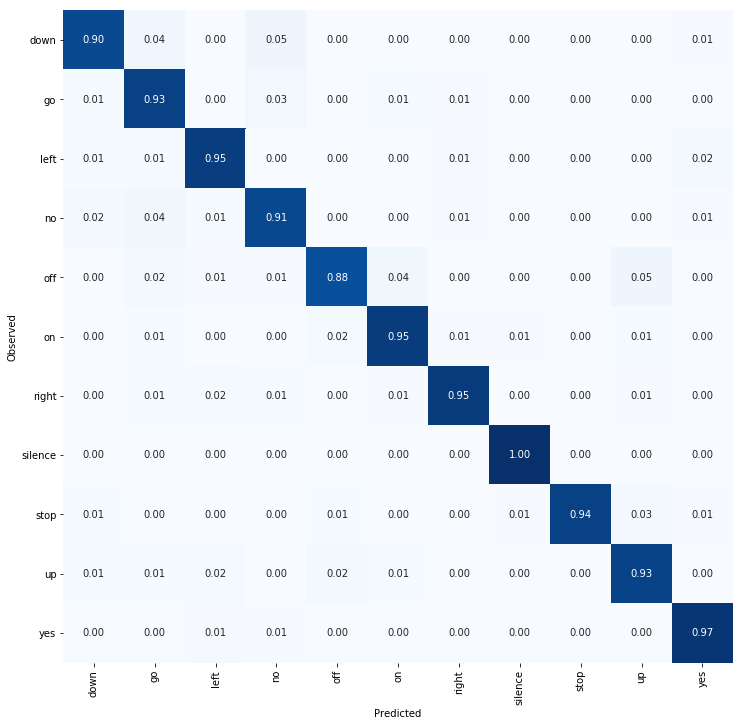

In [13]:
y_pred_val = model.predict_classes(x=X_val_img)
helper.plot_confusion_matrix(y_val, y_pred_val);

# Classifying Non-Command Words

In [14]:
X_train_total, y_train_total = helper.get_fold_data('train')
X_val_total, y_val_total = helper.get_fold_data('validation')
X_test_total, y_test_total = helper.get_fold_data('test')

X_img_total = {'train': helper.reformat_X(X_train_total),
              'val': helper.reformat_X(X_val_total),
              'test': helper.reformat_X(X_test_total)}

y_obs_total = {'train': y_train_total,
               'val': y_val_total,
               'test': y_test_total}

y_pred_proba_total = {'train': model.predict(X_img_total['train']),
                      'val': model.predict(X_img_total['val']),
                      'test': model.predict(X_img_total['test'])}


y_pred_classes_total = {'train': model.predict_classes(X_img_total['train']),
                        'val': model.predict_classes(X_img_total['val']),
                        'test': model.predict_classes(X_img_total['test'])}

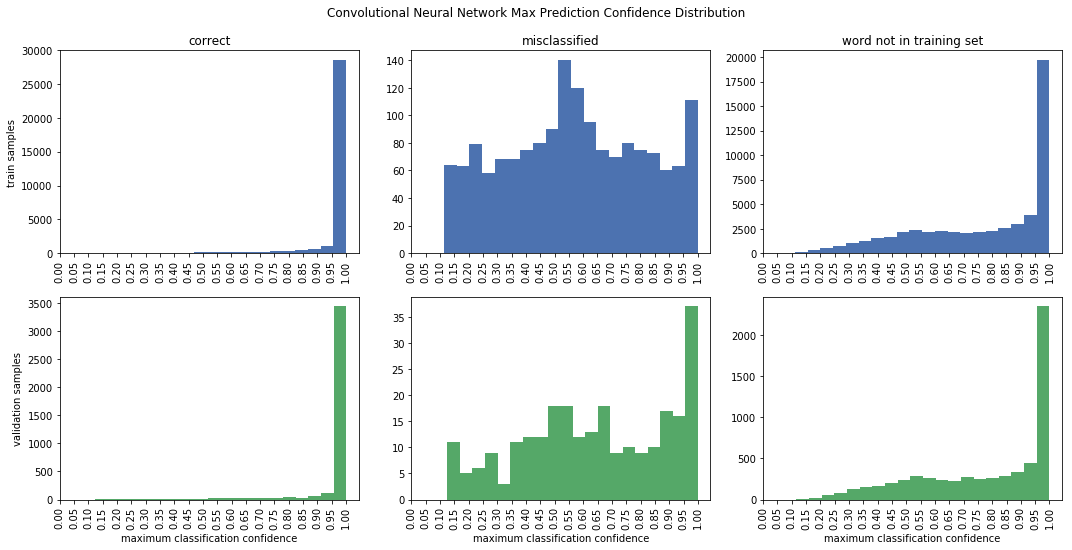

In [15]:
helper.plot_hist_grid(y_obs_total, y_pred_proba_total, y_pred_classes_total,
                      title='Convolutional Neural Network Max Prediction Confidence Distribution');

train accuracy: 0.6181092088991752
val accuracy: 0.6130764068641549
test accuracy: 0.6111741597555652


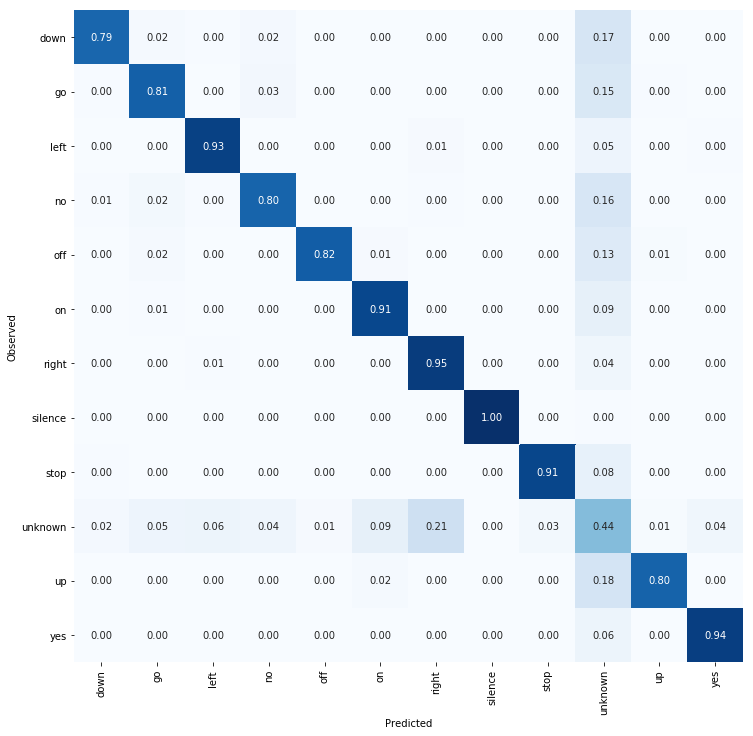

In [16]:
y_pred_modified = {
    fold: helper.modify_pred_classes(y_pred_proba_total[fold],
                                     y_pred_classes_total[fold], thresh=.8)
    for fold in ['train', 'val', 'test']
}


for fold in ['train', 'val', 'test']:
    print(fold, 'accuracy:', helper.score_with_unknown(y_obs_total[fold], y_pred_modified[fold]))
    
helper.plot_confusion_matrix(y_obs_total['test'], y_pred_modified['test'], words=helper.COMMAND_WORDS+['unknown']);

Overall, the accuracy actually went down slightly after the grid search. This is likely due to only searching over a random subset of the training data. To find the true optimal hyperparameters, I will likely have to search over the entire data set. Still, with the default values we have accomplished the initial goal of creating a very successful simple speech recognition system.